# Place cell analyisis

In [1]:
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

In [2]:
def slice_data(subset,position,times,spike_times):

    sliced_spikes = [[] for i in spike_times]
    for i in range(len(subset)):
        row = subset.iloc[i]

        # On- and offset definition within the trial.
        onset = row['env_onset'].astype(int)
        offset = row['tunnel1_onset']

        pos_segment = position[onset:offset]
        time_segment = times[onset:offset]
        #print(f"{i}: position: {np.min(pos_segment)}-{np.max(pos_segment)}")
        #print(f'times: {np.min(time_segment)}-{np.max(time_segment)}')

        # Normalize
        pos_segment = (pos_segment - np.min(pos_segment)) / (
            np.max(pos_segment) - np.min(pos_segment)
        )

        for j,cell_spikes in enumerate(spike_times):
            sl_sp = [s for s in cell_spikes if (s>=times[onset] and s<=times[offset])]
            #if len(sl_sp)>0:
                #print(f'min_spike = {np.min(sl_sp)}, max_spike = {np.max(sl_sp)}')
            sliced_spikes[j] += sl_sp

        if i == 0:
            norm_pos = pos_segment
            sliced_time = time_segment
        else:
            norm_pos = np.hstack([norm_pos, pos_segment])
            sliced_time = np.hstack([sliced_time, time_segment])

    return norm_pos,sliced_time,sliced_spikes
    

def skaggs_info_perspike(rate_map, occupancy_prob, epsilon=pow(10, -15)):
    """
    Calculates the Skaggs' information per spike for a single neuron.

    Parameters:
        rate_map (ndarray): A 1-dimensional array representing the rate map of the neuron.
            Each element corresponds to the firing rate at a specific location or bin.
        occupancy_prob (ndarray): A 1-dimensional array representing the occupancy histogram.
            Each element represents the probability of occupancy for a specific location or bin.
        epsilon (float, optional): A small value added to the rate to avoid division by zero.
            Defaults to 1e-15.

    Returns:
        float: The Skaggs' information per spike value for the neuron.
            It quantifies the spatial information content carried by the neuron's spikes.

    Notes:
        The Skaggs' information per spike is calculated using the following formula:
        sum(rate_map * np.log2((rate_map + epsilon) / avg_rate) * occupancy_prob) / avg_rate

        where avg_rate is the average firing rate of the neuron computed as:
        avg_rate = np.sum(rate_map * occupancy_prob)

        If the average firing rate (avg_rate) is less than or equal to epsilon, the function
        returns np.nan (not a number) to indicate that the result is undefined.

    Example:
        rate_map = np.array([1.5, 2.0, 0.8, 1.2])
        occupancy_prob = np.array([0.25, 0.35, 0.15, 0.25])
        info_per_spike = skaggs_info_perspike(rate_map, occupancy_prob)
        print(info_per_spike)  # Output: 0.851251...

    """
    rate_map = rate_map.flatten()
    occupancy_prob = occupancy_prob.flatten()
    avg_rate = np.sum(rate_map * occupancy_prob)
    if avg_rate > epsilon:
        return (
            sum(rate_map * np.log2((rate_map + epsilon) / avg_rate) * occupancy_prob)
            / avg_rate
        )
    else:
        return np.nan
    
def compute_firing_rate_maps(spike_positions, norm_pos):
    """
    Compute firing rate maps based on spike positions and normalized positions.

    Args:
        spike_positions (array-like): Array of spike positions.
        norm_pos (array-like): Array of normalized positions.

    Returns:
        numpy.ndarray: Firing rate maps.
        numpy.ndarray: Occupancy.
    """
    # Range of position = norm_pos, number of bins is 40 (1/0,025)
    space_bins = np.arange(0.0, 1.0, 0.025)
    vr_dt = 1 / 1000.0  # Frequency of VR-acquisition system

    # Compute histograms for each cell.
    spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]

    # Put them together into a matrix of floating-point numbers (for plotting).
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)

    # Compute occupancy histogram to normalize the firing rate maps.
    occupancy = np.histogram(norm_pos, space_bins)[0] * vr_dt

    # Compute firing rate maps.
    firing_rate_maps = spikes_hist / occupancy

    return firing_rate_maps, occupancy

def calculate_spatial_info(firing_rate_maps, occupancy):
    """
    Calculate the spatial information for each neuron given firing rate maps and occupancy.

    Parameters:
        firing_rate_maps (numpy.ndarray): 2D array of firing rate maps, where each row represents a neuron and each column represents a spatial bin.
        occupancy (numpy.ndarray): 1D array of occupancy values for each spatial bin.

    Returns:
        spatial_info (numpy.ndarray): 1D array of spatial information values for each neuron.

    """
    # Calculate occupancy probability
    occupancy_prob = occupancy / np.sum(occupancy)

    # Calculate spatial information for each neuron
    spatial_info = []
    for neuron in firing_rate_maps:
        spatial_info.append(skaggs_info_perspike(neuron, occupancy_prob))

    # Convert spatial_info to NumPy array
    spatial_info = np.array(spatial_info)

    # Remove NaN values from spatial_info
    spatial_info = spatial_info[~np.isnan(spatial_info)]

    return spatial_info

def shuffle_spikes(spike_times,end_time,min_shift=10):

    shuffled_spikes= []
    for cell_spikes in spike_times:
        random_shift  = np.random.uniform(min_shift,end_time)
        shifted_spikes = [(s + random_shift) % end_time for s in cell_spikes]
        shuffled_spikes.append(shifted_spikes)

    return shuffled_spikes

In [6]:
# load data
data_folder = Path(r"Z:\davide\2p_data\441406_fiano")

animal = '441406_fiano'
date =  '20230331'

save_plots = True
output_folder = Path('./imgs')
output_folder.mkdir(exist_ok=True,parents=True)

data_path = data_folder.joinpath(f'{animal}/{date}')

trial_data_file = data_path.joinpath('trial_data.csv')
trial_data = pd.read_csv(trial_data_file)

bdata_file = data_path.joinpath('behaviour_data.pickle')
with open(bdata_file,'rb') as file:
    b_data = pickle.load(file)

ndata_file = data_path.joinpath('neural_data.pickle')
with open(ndata_file,'rb') as file:
    n_data = pickle.load(file)


scanner_fps = 30.
vr_fps = 1000.

end_time = n_data['traces'].shape[1]/scanner_fps
scanner_times = np.arange(0, end_time, 1./scanner_fps)

position = b_data["position"]
times = b_data["time"]
spikes = n_data["deconvolved"]

spike_times = []
for s in spikes:
    spike_times.append(scanner_times[s])

FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\davide\\2p_data\\441406_fiano\\441406_fiano\\20230331\\trial_data.csv'

In [ ]:
env = 1

subset = trial_data[trial_data['env_label'] == env]
norm_pos,sliced_time,sliced_spikes = slice_data(subset,position,times,spike_times)
spike_positions = [np.interp(s,sliced_time , norm_pos) for s in sliced_spikes]

In [ ]:
# plot the spike for each cell in time and position, interactively
from ipywidgets import interact
import ipywidgets as widgets

def plot_cell(cell):

    plt.figure(figsize=(20,5))
    plt.scatter(sliced_time,norm_pos,s=0.01)
    plt.scatter(sliced_spikes[cell],spike_positions[cell],c='r')

interact(plot_cell, cell = widgets.IntSlider(min=0, max=(len(sliced_spikes)),step=1, value=0))

interactive(children=(IntSlider(value=0, description='cell', max=231), Output()), _dom_classes=('widget-intera…

<function __main__.plot_cell(cell)>

In [ ]:
firing_rate_maps, occupancy = compute_firing_rate_maps(spike_positions, norm_pos)
spatial_info = calculate_spatial_info(firing_rate_maps, occupancy)

<ipython-input-99-085a597f8c6c>:1: RuntimeWarning: invalid value encountered in true_divide
  norm_maps = firing_rate_maps/np.max(firing_rate_maps,axis=1)[:,np.newaxis]


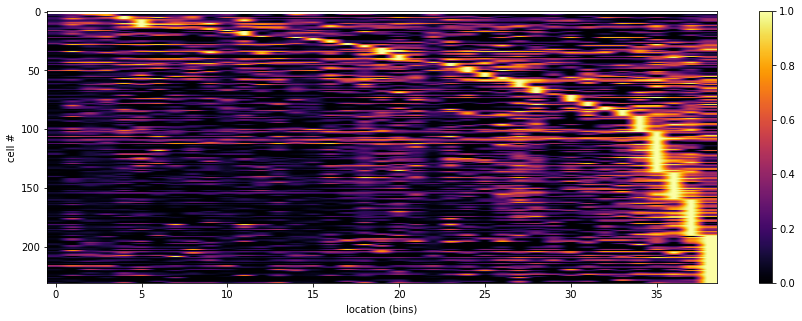

In [ ]:
norm_maps = firing_rate_maps/np.max(firing_rate_maps,axis=1)[:,np.newaxis]
plt.figure(figsize=(15, 5))

# Find the location of the peak firing rate for each cell
peak_locations = norm_maps.argmax(axis=1)

# Sort the firing rate maps based on the peak locations
ix = np.argsort(peak_locations)

# Plot the sorted firing rate maps
plt.imshow(norm_maps[ix, :], cmap="inferno", aspect="auto")

# Set the x-axis label
plt.xlabel("location (bins)")

# Set the y-axis label
plt.ylabel("cell #")

# Add a colorbar to the plot
plt.colorbar()

In [ ]:
# NULL
n_shuff = 20
null_spatial_info_distr = []

for n in range(n_shuff):
    shuff_spike_times = shuffle_spikes(spike_times,scanner_times[-1])
    shuff_norm_pos,shuff_sliced_time,shuff_sliced_spikes = slice_data(subset,position,times,shuff_spike_times)
    shuff_spike_positions = [np.interp(s,shuff_sliced_time , shuff_norm_pos) for s in shuff_sliced_spikes]
    
    shuff_firing_rate_maps, shuff_occupancy = compute_firing_rate_maps(shuff_spike_positions, shuff_norm_pos)
    shuff_spatial_info = calculate_spatial_info(shuff_firing_rate_maps, shuff_occupancy)

    for s in shuff_spatial_info:
        null_spatial_info_distr.append(s)

Text(0, 0.5, 'probability density')

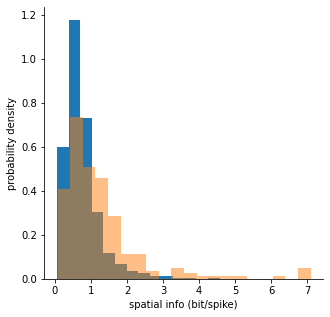

In [ ]:
plt.figure(figsize=(5,5))
plt.hist(null_spatial_info_distr,density=True,bins=20);
plt.hist(spatial_info,density=True,alpha=0.5,bins=20);
sns.despine()
plt.xlabel('spatial info (bit/spike)')
plt.ylabel('probability density')

In [ ]:
place_cell_th = np.percentile(null_spatial_info_distr,95)
n_place_cells = 0
for i in spatial_info:
    if i>place_cell_th:
        n_place_cells += 1

print(f'place cells {n_place_cells}/{len(spatial_info)}, fraction: {n_place_cells/len(spatial_info)}')

place cells 46/229, fraction: 0.20087336244541484
